In [2]:
import numpy as np
import poke.poke_core as pol
import poke.plotting as plot
from astropy.io import fits
import astropy.units as u
import poppy
import matplotlib.pyplot as plt

In [3]:
# load jones pupil
pth = 'Subaru_M1-M3_750nm.fits'
jones_pupil = fits.open(pth)[0].data

# load scexao pupil
pupil_pth = 'scexao_pupil.fits'
pupil_data = fits.open(pupil_pth)[0].data

# Reclaim the complex numbers from the fits file ;-;
J11 = jones_pupil[:,:,0,0,0] + 1j*jones_pupil[:,:,0,0,1]
J12 = jones_pupil[:,:,0,1,0] + 1j*jones_pupil[:,:,0,1,1]

J21 = jones_pupil[:,:,1,0,0] + 1j*jones_pupil[:,:,1,0,1] 
J22 = jones_pupil[:,:,1,1,0] + 1j*jones_pupil[:,:,1,1,1] 

J11 *= pupil_data
J12 *= pupil_data
J21 *= pupil_data
J22 *= pupil_data

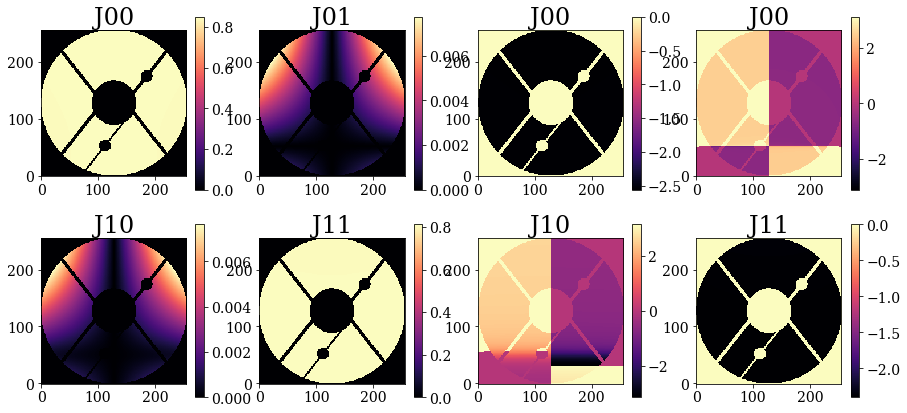

In [4]:
# Amplitude variation isn't shown in the on-diagonal elements because of the scale, but it's there!
plot.PlotJonesArray(J11,J12,J21,J22)

In [23]:
# Need a polarization state at two points in the pupil, some cases that might be interesting
# - Symmetric points
# - points along the plane of symmetry
# - anti-symmetric points

E = np.array([1,1])/np.sqrt(2)
Ex_out = J11*E[0] + J12*E[1]
Ey_out = J12*E[0] + J22*E[1]

# How big is the pupil?
dim = J11.shape[0]
quart = int(dim/4)

# Symmetric Points
# p1x = Ex_out[int(dim/2),quart]
# p2x = Ex_out[int(dim/2),int(dim/2 + quart)]
# p1y = Ey_out[int(dim/2),quart]
# p2y = Ey_out[int(dim/2),int(dim/2 + quart)]

p1x = Ex_out[int(dim/2),quart]
p2x = Ex_out[int(dim/2 + quart),int(dim/2)]
p1y = Ey_out[int(dim/2),quart]
p2y = Ey_out[int(dim/2 + quart),int(dim/2)]

E_out_1 = np.array([p1x,p1y])
E_out_2 = np.array([p2x,p2y])


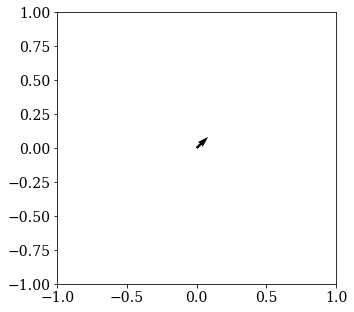

In [24]:
# Plot on Complex Plane

plt.figure(figsize=[5,5])
plt.quiver(np.abs(E_out_1[0]),np.abs(E_out_1[1]))
plt.quiver(np.abs(E_out_2[0]),np.abs(E_out_2[1]))
# plt.quiver(E_out_2)
plt.xlim([-1,1])
plt.ylim([-1,1])
plt.show()

In [25]:
def ComputePolarizationEllipseFromJones(J):

    Ax = np.abs(J[0])
    Ay = np.abs(J[1])

    phx = np.angle(J[0])
    phy = np.angle(J[1])

    phi = phx-phy

    psi = 0.5*np.arctan2(2*Ax*Ay*np.cos(phi),(Ax**2 - Ay**2))

    a = np.sqrt(Ax**2 * np.cos(psi)**2 + Ay**2 * np.sin(psi)**2 + 2*Ax*Ay*np.cos(psi)*np.sin(psi)*np.cos(phi))
    b = np.sqrt(Ax**2 * np.sin(psi)**2 + Ay**2 * np.cos(psi)**2 - 2*Ax*Ay*np.cos(psi)*np.sin(psi)*np.cos(phi))

    return psi,a,b

In [26]:
psi,a,b = ComputePolarizationEllipseFromJones(E_out_1)

In [27]:
print('E1 out = <',np.abs(E_out_1[0]),' exp[i',np.angle(E_out_1[0]),'] , ',np.abs(E_out_1[1]),' exp[i',np.angle(E_out_1[1]),']>')
print('E1 out = <',np.abs(E_out_2[0]),' exp[i',np.angle(E_out_2[0]),'] , ',np.abs(E_out_2[1]),' exp[i',np.angle(E_out_2[1]),']>')

E1 out = < 0.5995363092168089  exp[i -2.5490484226207424 ] ,  0.5744345787165324  exp[i -2.3963311947942247 ]>
E1 out = < 0.5998989917267095  exp[i -2.5514127064110745 ] ,  0.5727627079740262  exp[i -2.385464308197305 ]>


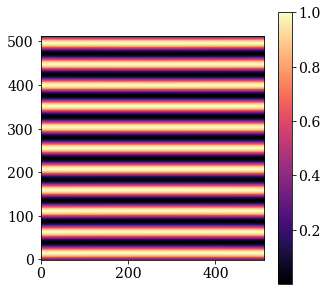

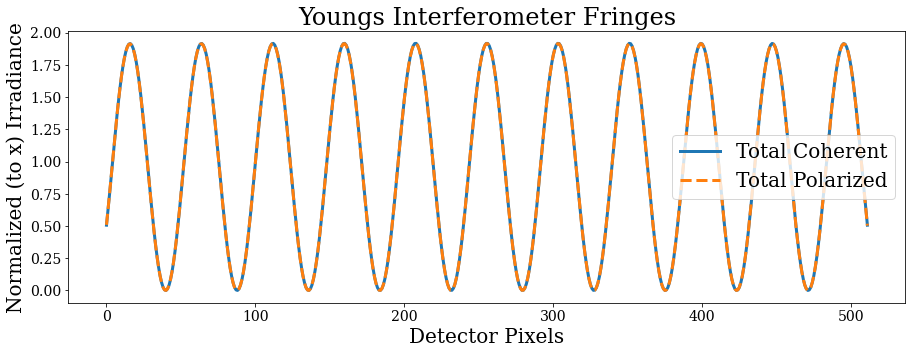

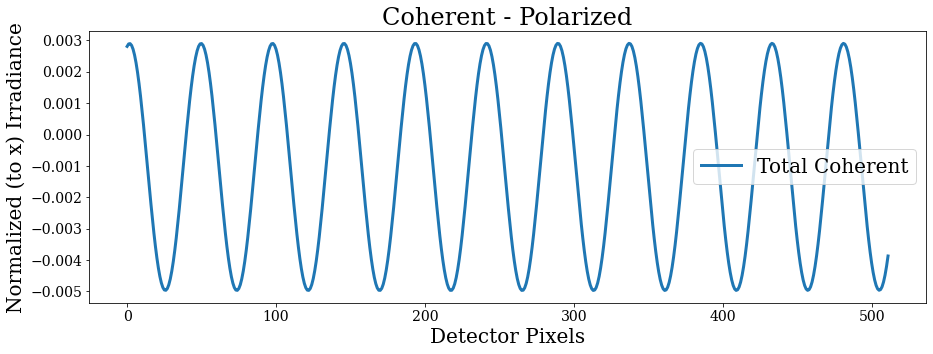

Coherent Assumption
Fringe Visibility =  0.9994945913389819
Using Polarized Pupil
Fringe Visibility =  0.9995870526453807


In [28]:
# Young's Double Pinhole Interferometer, but with Polarization!
# Dear god what's the equation ... maybe we can use poppy

def SphericalWave(d,amp,phase,wavelength):

    R = 25.4e-4
    npix = 512
    x = np.linspace(-R/25,R/25,npix)
    x,y = np.meshgrid(x,x)
    k = 2*np.pi/wavelength
    r = np.sqrt(x**2 + (y-d)**2 + R**2)
    E = amp*np.exp(1j*k*r)/r * np.exp(1j*phase)
    
    return E

E1 = SphericalWave(5e-5,np.abs(E_out_1[0]),np.angle(E_out_1[0]),750e-9)
E2 = SphericalWave(-5e-5,np.abs(E_out_1[0]),np.angle(E_out_1[0]),750e-9)
Efield_ref_x = E1 + E2

E1 = SphericalWave(5e-5,np.abs(E_out_1[0]),np.angle(E_out_1[0]),750e-9)
E2 = SphericalWave(-5e-5,np.abs(E_out_2[0]),np.angle(E_out_2[0]),750e-9)
Efield_test_x = E1 + E2

E1 = SphericalWave(5e-5,np.abs(E_out_1[1]),np.angle(E_out_1[1]),750e-9)
E2 = SphericalWave(-5e-5,np.abs(E_out_1[1]),np.angle(E_out_1[1]),750e-9)
Efield_ref_y = E1 + E2

E1 = SphericalWave(5e-5,np.abs(E_out_1[1]),np.angle(E_out_1[1]),750e-9)
E2 = SphericalWave(-5e-5,np.abs(E_out_2[1]),np.angle(E_out_2[1]),750e-9)
Efield_test_y = E1 + E2

I_ref_x = np.abs((Efield_ref_x)*np.conj(Efield_ref_x))
I_test_x = np.abs((Efield_test_x)*np.conj(Efield_test_x))

I_ref_y = np.abs((Efield_ref_y)*np.conj(Efield_ref_y))
I_test_y = np.abs((Efield_test_y)*np.conj(Efield_test_y))

I_test_x /= np.max(I_ref_x)
I_test_y /= np.max(I_ref_x)
I_ref_y /= np.max(I_ref_x)
I_ref_x /= np.max(I_ref_x)

plt.figure(figsize=[5,5])
plt.imshow(I_test_x)
plt.colorbar()
plt.show()

plt.figure(figsize=[15,5])
plt.title('Youngs Interferometer Fringes')
plt.xlabel('Detector Pixels')
plt.ylabel('Normalized (to x) Irradiance')
# plt.plot(I_ref_x[:,256],label='X Coherent',linewidth=3)
# plt.plot(I_test_x[:,256],label='X Polarized',linewidth=3,linestyle='--')
# plt.plot(I_ref_y[:,256],label='Y Coherent',linewidth=3,linestyle='--')
# plt.plot(I_test_y[:,256],label='Y Polarized',linewidth=3,linestyle='--')
plt.plot(I_ref_x[:,256]+I_ref_y[:,256],label='Total Coherent',linewidth=3)
plt.plot(I_test_x[:,256]+I_test_y[:,256],label='Total Polarized',linewidth=3,linestyle='--')
plt.legend()
plt.show()

plt.figure(figsize=[15,5])
plt.title('Coherent - Polarized')
plt.xlabel('Detector Pixels')
plt.ylabel('Normalized (to x) Irradiance')
plt.plot(I_test_x[:,256]+I_test_y[:,256]-I_ref_x[:,256]-I_ref_y[:,256],label='Total Coherent',linewidth=3)
# plt.plot((I_ref_x[:,256]-I_test_x[:,256]))
# plt.plot((I_ref_y[:,256]-I_test_y[:,256]))
plt.legend()
plt.show()

def PrintVisibility(field):

    max_field = np.max(field)
    min_field = np.min(field)

    print('Fringe Visibility = ',(max_field-min_field)/(max_field+min_field))

print('Coherent Assumption')
PrintVisibility(I_ref_x[:,256]+I_ref_y[:,256])

print('Using Polarized Pupil')
PrintVisibility(I_test_x[:,256]+I_test_y[:,256])